## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

## load data

In [2]:
df=pd.read_csv('clv_data.csv')
df.head()

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases
0,0,0,NaN,Male,126895,14.0,San Francisco,0
1,1,1,NaN,Male,161474,14.0,Tokyo,0
2,2,2,24.0,Male,104723,34.0,London,1
3,3,3,29.0,Male,43791,28.0,London,2
4,4,4,18.0,Female,132181,26.0,London,2


## boxplot

<Axes: ylabel='purchases'>

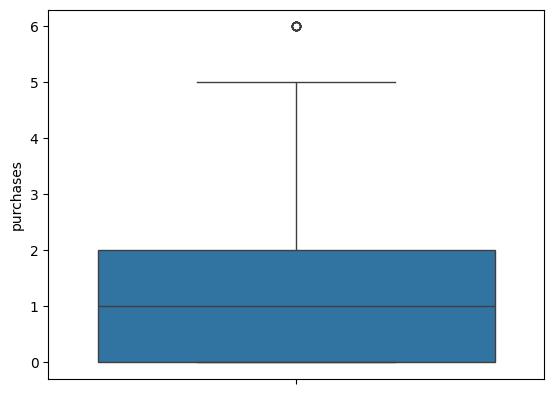

In [4]:
sns.boxplot(df['purchases'])

In [16]:
def extract_outliers_from_boxplot(df1:pd.DataFrame):
    q1=np.quantile(df1,0.25)
    q3=np.quantile(df1,0.75)
    iqr=q3-q1
    upper=q3+1.5*iqr
    lower=q1-1.5*iqr
    outlier=df1[(df1<=lower)|(df1>=upper)]
    return outlier
    

In [17]:
extract_outliers_from_boxplot(df['purchases'])

47      5
104     5
142     5
301     5
323     5
485     6
486     5
1026    5
1104    6
1112    5
1120    6
1125    5
1374    5
1504    5
1623    5
1669    6
1670    5
1809    6
1818    5
1836    5
1870    5
2180    5
2463    6
2548    5
2572    5
2605    5
2717    5
2901    5
3032    6
3080    5
3105    5
3162    5
3170    5
3291    5
3298    5
3321    5
3361    5
3380    5
3410    5
3566    5
3603    6
3631    6
3835    5
3848    5
4003    6
4141    5
4334    5
4346    5
4545    5
4597    5
4611    5
4620    5
4662    5
4691    5
4728    5
4751    5
4761    5
4895    5
4958    5
Name: purchases, dtype: int64

## Violin Plot

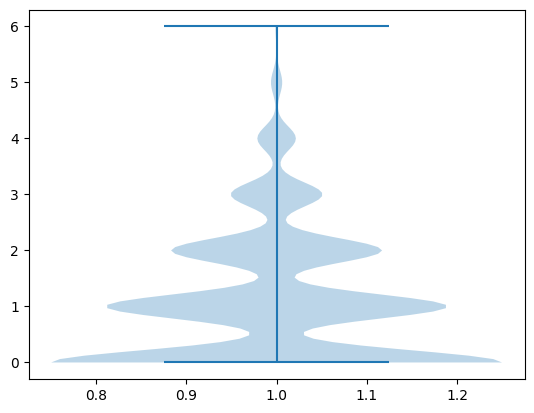

In [15]:
plt.violinplot(df['purchases'])
plt.show()

## Z-score

In [18]:
def percentile_outliers(df1:pd.Series,lower_bound,upper_bound):
    l=np.percentile(df1,lower_bound)
    u=np.percentile(df1,upper_bound)
    outlier=df1[(df1<=l)|(df1>=u)]
    return outlier

def zscore_outlier(df1:pd.Series,lower_bound,upper_bound):
    score=scipy.stats.zscore(df1)
    outlier=df1[(df1<-1.96)|(df1>1.96)]
    return outlier
    

## Isolation Forests

In [23]:
from sklearn.ensemble import IsolationForest

features = ['age','income','days_on_platform','purchases']

## We'll do a simple drop null for now
df = df.dropna()

## Create a training-test set
X = df[features]
X_train = X[:4000]
X_test = X[1000:]

## Fit Model
clf = IsolationForest(n_estimators=50, max_samples=100)
clf.fit(X_train)

## Get Scores
df['scores'] = clf.decision_function(X_train)
df['anomaly'] = clf.predict(X)

## Get Anomalies
outliers=df[(df['anomaly']==-1)]

outliers

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,scores,anomaly
9,9,9,49.0,Female,76842,19.0,Tokyo,2,-0.026293,-1
15,15,15,31.0,Female,226249,20.0,Miami,0,-0.031568,-1
17,17,17,27.0,Female,177582,2.0,London,0,-0.020629,-1
18,18,18,10.0,Female,260,32.0,San Francisco,0,-0.034325,-1
23,23,23,10.0,Female,108804,5.0,Tokyo,2,-0.027888,-1
...,...,...,...,...,...,...,...,...,...,...
4969,4969,4969,49.0,Female,28243,13.0,New York City,0,-0.015980,-1
4970,4970,4970,34.0,Female,9850,3.0,New York City,3,-0.016508,-1
4979,4979,4979,50.0,Male,90750,71.0,New York City,1,-0.115592,-1
4984,4984,4984,24.0,Female,225155,8.0,San Francisco,2,-0.066971,-1


# Outlier Treatment

## Removal

In [24]:
def percentile_outliers(df1:pd.Series,lower_bound,upper_bound):
    l=np.percentile(df1,lower_bound)
    u=np.percentile(df1,upper_bound)
    outlier=(df1<=l)|(df1>=u)
    return df1[~outlier]

def zscore_outlier(df1:pd.Series,lower_bound,upper_bound):
    score=scipy.stats.zscore(df1)
    outlier=(df1<-1.96)|(df1>1.96)
    return df1[~outlier]

## Winsorize

In [25]:
def winsorize(df, column, upper, lower):
    col_df = df[column]
    
    perc_upper = np.percentile(df[column],upper)
    perc_lower = np.percentile(df[column],lower)
    
    df[column] = np.where(df[column] >= perc_upper, 
                          perc_upper, 
                          df[column])
    
    df[column] = np.where(df[column] <= perc_lower, 
                          perc_lower, 
                          df[column])
    
    return df